In [48]:
import numpy as np  # Used for creating rating / indicator functions
import pyam  # Useful for storing climate / energy scenario data
import pandas as pd

import pandas_indexing
from pandas_indexing import isin, ismatch, assignlevel, projectlevel, extractlevel, formatlevel

import data_shepherd as ds
from data_shepherd.utils import convert_unit
import datatoolbox as dt

import pycountry

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import seaborn as sns
sns.set_palette("colorblind")

In [52]:
cat_filter = pd.read_csv('../data/processed/cat_filter_set.csv')
cat_filter = [f"{m}|{s}" for m, s in cat_filter.set_index(["model","scenario"]).index]

cat_filter_nodiff = pd.read_csv('../data/processed/cat_filter_set_noregdiff.csv')
cat_filter_nodiff = [f"{m}|{s}" for m, s in cat_filter_nodiff.set_index(["model","scenario"]).index]

filter_set = cat_filter

In [92]:
illu_pathways = [
    'Historic',
    'REMIND-MAgPIE 2.1-4.2|CEMICS_SSP1-1p5C-minCDR',
       'REMIND-MAgPIE 2.1-4.2|NGFS2_Net-Zero 2050 - IPD-95th',
       'REMIND-MAgPIE 2.1-4.2|SusDev_SSP1-PkBudg900',
       'REMIND-MAgPIE 2.1-4.3|DeepElec_SSP2_ HighRE_Budg900']

In [19]:
def name_to_iso(name):
    if pycountry.countries.get(name = name) is None:
        return(None)
    else:
        return(pycountry.countries.get(name = name).alpha_3)

## Load data

In [14]:
mdps = pyam.IamDataFrame('../data/processed/algo_downscaling_data2019.csv')
mdps = pyam.IamDataFrame(mdps.timeseries().droplevel(level=["downscaling","harmonisation"]))

pyam.core - INFO: Reading file ../data/processed/algo_downscaling_data2019.csv


In [15]:
mdps.append(
    (
        ds.utils.convert_unit(mdps, "Mt CO2e / yr", context="AR4GWP100")#config.GWP)
        .aggregate(
            "Emissions",
            [
                v for v in mdps.variable
                if not v.endswith("Industrial Processes")
            ] + ["Emissions|KYOTOGHGAR4|Industrial Processes"]
        )
    ),
    inplace=True
)

In [16]:
mdps.meta["pathway"] = [f"{m}|{s}" for m,s in mdps.meta.index]

In [17]:
hdi_data = pd.read_excel('../data/raw/HDR21-22_Statistical_Annex_HDI_Table.xlsx',
                        skiprows=5)

hdi_data = hdi_data[["Country","Value"]]
hdi_data = hdi_data.dropna()
hdi_data.replace("..",np.nan,inplace=True)
# hdi_data.reset_index(inplace=True)
hdi_data.head()

Country  Value
2             Switzerland  0.962
3                  Norway  0.961
4                 Iceland  0.959
5  Hong Kong, China (SAR)  0.952
6               Australia  0.951

In [20]:
hdi_data["ISO"] = hdi_data.Country.apply(lambda str:name_to_iso(str))

In [21]:
hdi_data.set_index("ISO",inplace=True)
hdi_data

Country  Value
ISO                                                           
CHE                                         Switzerland  0.962
NOR                                              Norway  0.961
ISL                                             Iceland  0.959
None                             Hong Kong, China (SAR)  0.952
AUS                                           Australia  0.951
...                                                 ...    ...
None                                 Sub-Saharan Africa  0.547
None                          Least developed countries  0.540
None                     Small island developing states  0.730
None  Organisation for Economic Co-operation and Dev...  0.899
None                                              World  0.732

[210 rows x 2 columns]

We split into developed vs. developing using the HDI threshold of 0.8, which is those in a state of "Very High Human Development" (https://en.wikipedia.org/wiki/Human_Development_Index). This could be revised to be lower

In [22]:
developed = hdi_data.loc[hdi_data.Value>=0.8]
developed = list(developed.index.drop(None))

developing = hdi_data.loc[hdi_data.Value<0.8]
developing = list(developing.index.drop(None))

In [24]:
mdps.aggregate_region(
    "Emissions",
    "developed",
    developed,
    append=True
)

mdps.aggregate_region(
    "Emissions",
    "developing",
    developing,
        append=True
    )

We explore the % reduction in emissions from 2020-2030 as our metric for the regional differentation in the pathway

In [53]:
mdps = mdps.filter(pathway=filter_set)

In [54]:
regional_mitigation = (
    mdps.filter(
        variable="Emissions",
        year=2030
    )._data.droplevel("year") / 
    mdps.filter(
        variable="Emissions",
        year=2020
    )._data.droplevel("year") 
)

In [55]:
regional_differentation = (
    regional_mitigation.loc[isin(region="developed")].droplevel("region") - 
    regional_mitigation.loc[isin(region="developing")].droplevel("region"))

In [56]:
projectlevel(regional_differentation,['model','scenario'])

model                  scenario                           
COFFEE 1.1             EN_NPi2020_400                        -0.053514
MESSAGEix-GLOBIOM_1.1  NGFS2_Net-Zero 2050                   -0.015051
REMIND 2.1             LeastTotalCost_LTC_brkLR15_SSP1_P50   -0.102365
                       R2p1_SSP1-PkBudg900                   -0.166224
REMIND-MAgPIE 2.1-4.2  CEMICS_SSP1-1p5C-fullCDR              -0.157917
                       CEMICS_SSP1-1p5C-minCDR               -0.126940
                       EN_NPi2020_200f                       -0.036137
                       EN_NPi2020_300f                       -0.041803
                       EN_NPi2020_400                        -0.033086
                       EN_NPi2020_400f                       -0.054719
                       EN_NPi2020_500                        -0.024530
                       NGFS2_Divergent Net Zero Policies     -0.115147
                       NGFS2_Net-Zero 2050                   -0.095594
                  

Text(0.5, 1.0, 'Regional differentiation in 2020-2030 \nemissions reductions')

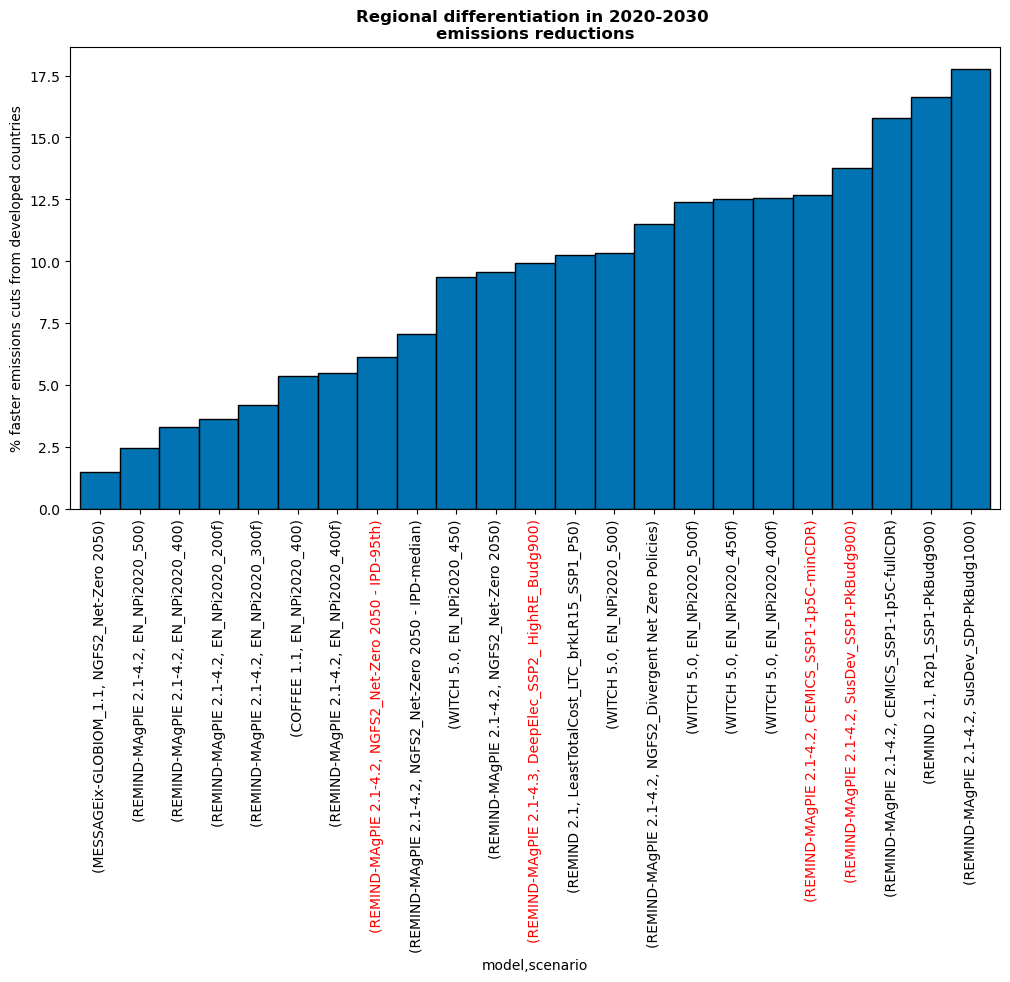

In [76]:
f, ax = plt.subplots(figsize=(12,6))
projectlevel(regional_differentation*-1e2,['model','scenario']).sort_values().plot.bar(width=1,edgecolor='k')
ax.set_ylabel('% faster emissions cuts from developed countries')

plt.gca().get_xticklabels()[7].set_color('r')
plt.gca().get_xticklabels()[11].set_color('r')
plt.gca().get_xticklabels()[18].set_color('r')
plt.gca().get_xticklabels()[19].set_color('r')

ax.set_title('Regional differentiation in 2020-2030 \nemissions reductions',
            fontweight='bold')

In [33]:
mdps.filter(variable='Emissions|CO2|Energy')

<class 'pyam.core.IamDataFrame'>
Index:
 * model    : AIM/CGE 2.2, COFFEE 1.1, IMAGE 3.2, ... WITCH 5.0 (9)
 * scenario : CEMICS_SSP1-1p5C-fullCDR, CEMICS_SSP1-1p5C-minCDR, ... SusDev_SSP1-PkBudg900 (37)
Timeseries data coordinates:
   region   : ABW, AFG, AGO, ALB, ARE, ARG, ARM, AUS, AUT, AZE, ... R10ROWO (192)
   variable : Emissions|CO2|Energy (1)
   unit     : Mt CO2 / yr (1)
   year     : 2019, 2020, 2025, 2030, 2035, 2040, 2045, 2050, ... 2100 (18)
Meta indicators:
   exclude (bool) False (1)
   pathway (object) AIM/CGE 2.2|EN_NPi2020_300f, ... WITCH 5.0|EN_NPi2020_500f (46)

In [39]:
mdps.filter(region='developing').timeseries()

2019  \
model                 scenario                            region     variable  unit                         
AIM/CGE 2.2           EN_NPi2020_300f                     developing Emissions Mt CO2e / yr  26197.990392   
COFFEE 1.1            EN_NPi2020_400                      developing Emissions Mt CO2e / yr  26058.202744   
IMAGE 3.2             SSP1_SPA1_19I_D_LB                  developing Emissions Mt CO2e / yr  26197.990392   
                      SSP1_SPA1_19I_RE_LB                 developing Emissions Mt CO2e / yr  26197.990392   
                      SSP2_SPA1_19I_D_LB                  developing Emissions Mt CO2e / yr  26197.990392   
                      SSP2_SPA1_19I_LIRE_LB               developing Emissions Mt CO2e / yr  26197.990392   
                      SSP2_SPA1_19I_RE_LB                 developing Emissions Mt CO2e / yr  26197.990392   
MESSAGEix-GLOBIOM_1.1 EN_NPi2020_450                      developing Emissions Mt CO2e / yr  26058.202744   
                      EN_NPi2020_500                      developing Emissions Mt CO2e / yr  26197.990392   
                      EN_NPi2020_600_COV                  developing Emissions Mt CO2e / yr  26197.990392   
                      EN_NPi2020_600_DR1p                 developing Emissions Mt CO2e / yr  26197.990392   
                      EN_NPi2020_600_DR2p                 developing Emissions Mt CO2e / yr  26197.990392   
                      EN_NPi2020_600_DR3p                 developing Emissions Mt CO2e / yr  26197.990392   
                      EN_NPi2020_600_DR4p                 developing Emissions Mt CO2e / yr  26197.990392   
                      NGFS2_Divergent Net Zero Policies   developing Emissions Mt CO2e / yr  26197.990392   
                      NGFS2_Net-Zero 2050                 developing Emissions Mt CO2e / yr  26197.990392   
MESSAGEix-GLOBIOM_1.2 COV_GreenPush_550                   developing Emissions Mt CO2e / yr  26197.990392   
                      COV_NoPolicyNoCOVID_550             developing Emissions Mt CO2e / yr  26197.990392   
                      COV_Restore_550                     developing Emissions Mt CO2e / yr  26197.990392   
                      COV_SelfReliance_550                developing Emissions Mt CO2e / yr  26197.990392   
                      COV_SmartUse_550                    developing Emissions Mt CO2e / yr  26197.990392   
REMIND 2.1            LeastTotalCost_LTC_brkLR15_SSP1_P50 developing Emissions Mt CO2e / yr  26197.990392   
                      R2p1_SSP1-PkBudg900                 developing Emissions Mt CO2e / yr  26197.990392   
REMIND-MAgPIE 2.1-4.2 CEMICS_SSP1-1p5C-fullCDR            developing Emissions Mt CO2e / yr  26197.990392   
                      CEMICS_SSP1-1p5C-minCDR             developing Emissions Mt CO2e / yr  26197.990392   
                      CEMICS_SSP2-1p5C-minCDR             developing Emissions Mt CO2e / yr  26197.990392   
                      EN_NPi2020_200f                     developing Emissions Mt CO2e / yr  26197.990392   
                      EN_NPi2020_300f                     developing Emissions Mt CO2e / yr  26197.990392   
                      EN_NPi2020_400                      developing Emissions Mt CO2e / yr  26197.990392   
                      EN_NPi2020_400f                     developing Emissions Mt CO2e / yr  26197.990392   
                      EN_NPi2020_500                      developing Emissions Mt CO2e / yr  26197.990392   
                      EN_NPi2020_600                      developing Emissions Mt CO2e / yr  26197.990392   
                      EN_NPi2020_600_COV                  developing Emissions Mt CO2e / yr  26197.990392   
                      EN_NPi2020_600f_COV                 developing Emissions Mt CO2e / yr  26197.990392   
                      NGFS2_Divergent Net Zero Policies   developing Emissions Mt CO2e / yr  26197.990392   
                      NGFS2_Net-Zero 2050                 developing

In [43]:
pyam.cumulative(mdps.filter(variable='Emissions',region='developing').timeseries().iloc[9],2020,2050)

435328.98620934336

In [42]:
mdps.filter(variable='Emissions',region='developing').timeseries().iloc[0]

2019    26197.990392
2020    26899.056260
2025    20270.935439
2030    15367.704671
2035    12616.360778
2040    12351.163138
2045    10863.183031
2050     8460.341525
2055     6286.861790
2060     4275.304625
2065     2539.277661
2070     1516.385670
2075     1163.589572
2080     1008.917630
2085      913.302504
2090      806.254779
2095      691.563698
2100      553.415922
Name: (AIM/CGE 2.2, EN_NPi2020_300f, developing, Emissions, Mt CO2e / yr), dtype: float64

In [77]:
# Power
power_sector_downscaled = pyam.IamDataFrame("../data/processed/powersector_data_processed.csv")
power_sector_downscaled.meta["pathway"] = [str.lstrip("v0.0__").replace("__","|") for str in power_sector_downscaled.scenario]


pyam.core - INFO: Reading file ../data/processed/powersector_data_processed.csv


In [121]:
sns.set_palette([(0,0,0)] + list(sns.color_palette()))

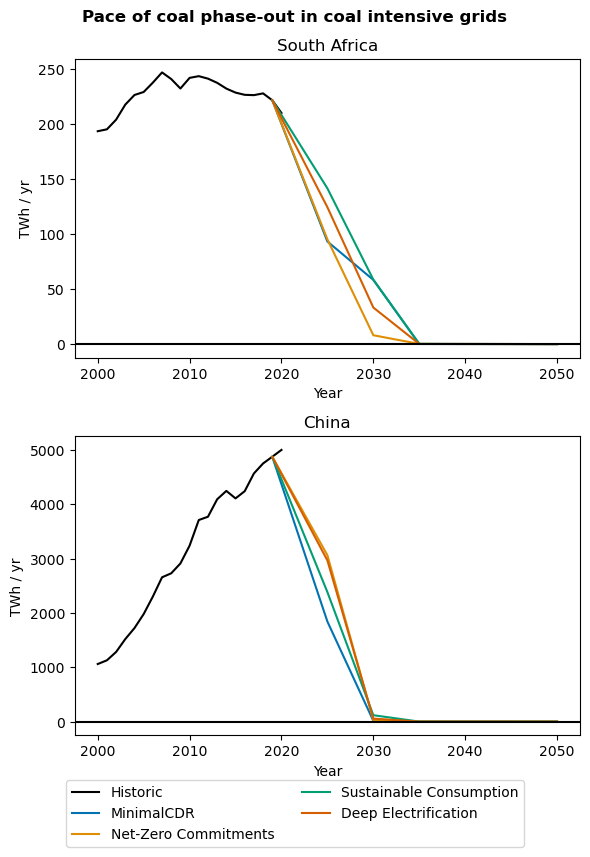

In [124]:
f, axes = plt.subplots(nrows=2,figsize=(6,8))

power_sector_downscaled.filter(
    variable='Secondary Energy|Electricity|Coal|w/o CCS',
    pathway=illu_pathways,
    year=range(2000,2051),
    region='ZAF').convert_unit('PWh / yr','TWh / yr').plot(ax=axes[0],legend=False)

axes[0].axhline(y=0,color='k')
axes[0].set_title('South Africa')

power_sector_downscaled.filter(
    variable='Secondary Energy|Electricity|Coal|w/o CCS',
    pathway=illu_pathways,
    year=range(2000,2051),
    region='CHN').convert_unit('PWh / yr','TWh / yr').plot(ax=axes[1],legend=False)

axes[1].axhline(y=0,color='k')
axes[1].set_title('China')


f.legend([
    'Historic',
    'MinimalCDR',
    'Net-Zero Commitments',
    'Sustainable Consumption',
    'Deep Electrification'
],
         ncol=2,
         loc='center',
         bbox_to_anchor=[0.5,-0.025]
         )

f.suptitle('Pace of coal phase-out in coal intensive grids',
           fontweight='bold')
plt.tight_layout()

Text(0.5, 1.0, 'Coal-fired electricity generation in South Africa')

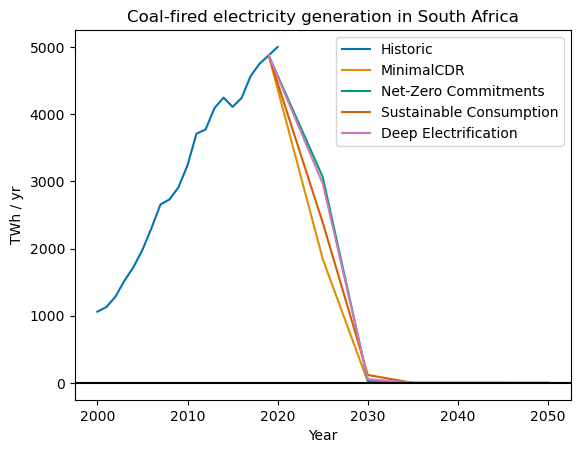

In [101]:
f, ax = plt.subplots()

power_sector_downscaled.filter(
    variable='Secondary Energy|Electricity|Coal|w/o CCS',
    pathway=illu_pathways,
    year=range(2000,2051),
    region='CHN').convert_unit('PWh / yr','TWh / yr').plot(ax=plt.gca())

ax.legend([
    'Historic',
    'MinimalCDR',
    'Net-Zero Commitments',
    'Sustainable Consumption',
    'Deep Electrification'
]
         )

ax.axhline(y=0,color='k')
ax.set_title('Coal-fired electricity generation in South Africa')